In [1]:
import pandas as pd
import xgboost as xgb 
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score,accuracy_score 
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import itertools

**Read Model Data**

In [2]:
X_train=pd.read_csv("./Model_Data/XGBOOST_X_train.csv")
X_test=pd.read_csv("./Model_Data/XGBOOST_X_test.csv")
y_train=pd.read_csv("./Model_Data/XGBOOST_y_train.csv")
y_test=pd.read_csv("./Model_Data/XGBOOST_y_test.csv")

In [3]:
X_train = X_train.drop(X_train.columns[0], axis=1)
X_test = X_test.drop(X_test.columns[0], axis=1)
y_train = y_train.drop(y_train.columns[0], axis=1)
y_test = y_test.drop(y_test.columns[0], axis=1)

**Set Model Parameters**

In [4]:
parameters={'max_depth': 6, 
            'eta' : 0.3,
            'objective':'binary:logistic',
            'seed' : 4241,
            'min_child_weight' : 5,
            'n_estimators' : 250
           }

**Train Model**

In [5]:
n_first = int(X_train.shape[0]*0.8)
model = xgb.XGBClassifier(**parameters, nthread = 1)
model = model.fit(X_train.iloc[:n_first], y_train[:n_first],
          eval_set = [(X_train.iloc[:n_first], y_train[:n_first]),
                      (X_train.iloc[n_first:], y_train[n_first:])],
          eval_metric = 'auc',
          verbose = True,
          early_stopping_rounds=20) 

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[0]	validation_0-auc:0.88369	validation_1-auc:0.88564
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.89466	validation_1-auc:0.89522
[2]	validation_0-auc:0.90180	validation_1-auc:0.90209
[3]	validation_0-auc:0.90494	validation_1-auc:0.90565
[4]	validation_0-auc:0.90920	validation_1-auc:0.90939
[5]	validation_0-auc:0.91098	validation_1-auc:0.91084
[6]	validation_0-auc:0.91308	validation_1-auc:0.91316
[7]	validation_0-auc:0.91497	validation_1-auc:0.91489
[8]	validation_0-auc:0.91665	validation_1-auc:0.91582
[9]	validation_0-auc:0.91842	validation_1-auc:0.91801
[10]	validation_0-auc:0.91998	validation_1-auc:0.91900
[11]	validation_0-auc:0.92168	validation_1-auc:0.91980
[12]	validation_0-auc:0.92265	validation_1-auc:0.92032
[13]	validation_0-auc:0.92339	validation_1-auc:0.92087
[14]	validation_0-auc:0.92457	validation_1-auc:0.92158
[15]	validation_0-auc:0.9255

**Plot Feature Importance**

In [6]:
def plot_feature_importance(model):
    feature_importance = pd.DataFrame({
        'feature': list(model.get_booster().get_score(importance_type = 'total_gain').keys()),
        'importance': list(model.get_booster().get_score(importance_type ='total_gain').values())})
    feature_importance.sort_values('importance', ascending = False, inplace = True)
    best_features = feature_importance.head(10)
    plt.figure(figsize = (8,6))
    sns.barplot(x = 'importance', y = 'feature', data = best_features)
    plt.show()

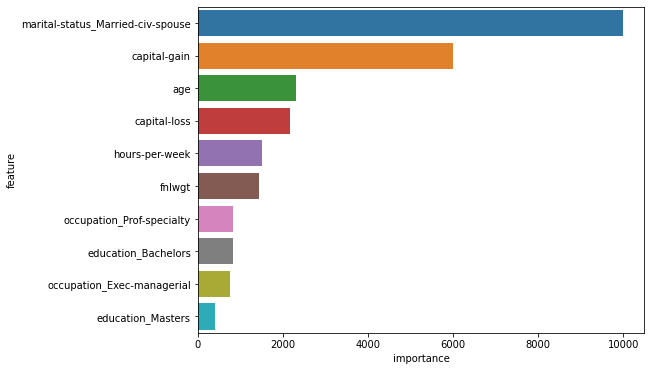

In [7]:
plot_feature_importance(model)

**Define Function for Plotting the Roc Curve**

In [8]:
def plot_roc_curve (X, y, model,which_set):
    y_pred = model.predict_proba(X, ntree_limit = model.get_booster().best_iteration)[:,1]
    fpr, tpr, threshold = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)    
    plt.figure()
    plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (area = %0.3f)' % (roc_auc))
    plt.plot([0,1],[0,1], color = 'navy', lw = 2, linestyle = '--')
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for '+ which_set+ ' Set')
    plt.legend()
    plt.show()
    
    return y_pred, fpr, tpr, threshold

**Apply the Plot on Validation Set and Get Predicted Probabilities, Gelt Each Threshold and Related True Positive and False positive Rates**

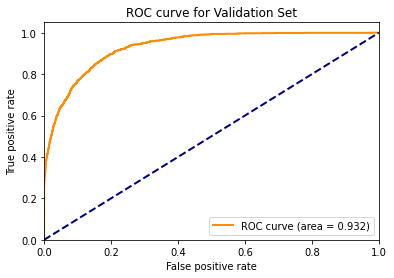

In [9]:
y_pred_valid, fpr_valid, tpr_valid, threshold_valid =plot_roc_curve(X_train.iloc[n_first:], y_train.iloc[n_first:], model,which_set="Validation")

**Define the Function for Getting Predicted Classes as well as Getting the Optimal Threshold obtained from Roc Curve** 

In [10]:
def prediction_with_optimal_auc(y_pred, tpr, fpr, threshold):
    

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]

    #Converting probabilities into 1 or 0  
    for i in range(0,(y_pred.shape[0])):
        if y_pred[i]>=optimal_threshold:
            y_pred[i]=1
        else: 
            y_pred[i]=0 
            
    return y_pred, optimal_threshold

In [11]:
y_pred_valid, optimal_treshold_valid = prediction_with_optimal_auc(y_pred_valid, tpr_valid, fpr_valid, threshold_valid)

In [12]:
optimal_treshold_valid

0.21393804

Seems like 0.21 is the threshold giving max tpr/fpr ratio. Since we have predicted classes obtained from this threshold, we can construct confusion matrices

**Define the Function for Plotting Confusion Matrix**

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    #tpr = tp/(tp+fn)
    tpr_optimum = cm[1,1] / (cm[1,1]+cm[1,0])
    #fpr = fp/(fp+tn)
    fpr_optimum = cm[0,1] / (cm[0,1]+cm[0,0])

    return tpr_optimum, fpr_optimum

**Apply the Function on Validation Set**

              precision    recall  f1-score   support

           0       0.96      0.81      0.88      4955
           1       0.59      0.89      0.71      1553

    accuracy                           0.83      6508
   macro avg       0.78      0.85      0.79      6508
weighted avg       0.87      0.83      0.84      6508

Normalized confusion matrix
[[0.81 0.19]
 [0.11 0.89]]

tpr_optimum:  0.8943979394719896
fpr_optimum :  0.19455095862764885

Accuracy of the model : 0.8266748617086662


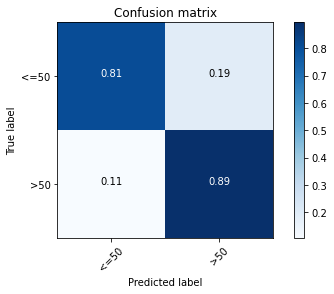

In [14]:
# Compute confusion matrix
cmf = confusion_matrix(y_train.iloc[n_first:], y_pred_valid)
np.set_printoptions(precision=2)

print (classification_report(y_train.iloc[n_first:], y_pred_valid))

# Plot non-normalized confusion matrix
plt.figure()
tpr_optimum, fpr_optimum = plot_confusion_matrix(cmf, classes=['<=50','>50'],normalize= True,  title='Confusion matrix')

print('''''')
print('tpr_optimum: ',tpr_optimum)
print('fpr_optimum : ',fpr_optimum)
#calculating accuracy of our model 
from sklearn.metrics import accuracy_score 
accuracy_xgb = accuracy_score(y_train.iloc[n_first:], y_pred_valid) 
print('''''')
print('Accuracy of the model :', accuracy_xgb)

Confusion matrix, without normalization
[[3991  964]
 [ 164 1389]]


(0.8943979394719896, 0.19455095862764885)

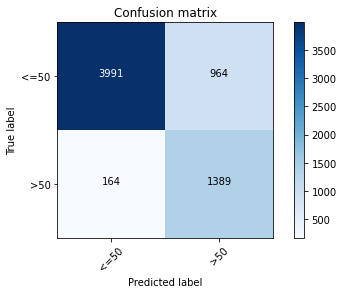

In [15]:
plot_confusion_matrix(cmf, classes=['<=50','>50'],normalize= False,  title='Confusion matrix')

**Define the Function for Plotting the Roc Curve, this time with the Optimal Threshold**

In [16]:
def plot_roc_curve_with_treshold (X, y, model, fpr_optimum, tpr_optimum,which_set):
    y_pred = model.predict_proba(X, ntree_limit = model.get_booster().best_iteration)[:,1]
    fpr, tpr, threshold = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)    
    plt.figure()
    plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (area = %0.3f)' % (roc_auc))
    plt.plot(fpr_optimum, tpr_optimum, color = 'red', lw = 2, label = 'Point for optimal threshold' ,marker=".", markersize=20)
    plt.plot([0,1],[0,1], color = 'navy', lw = 2, linestyle = '--')
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for '+which_set+' Set')
    plt.legend()
    plt.show()

**Apply the Function on Validation Set**

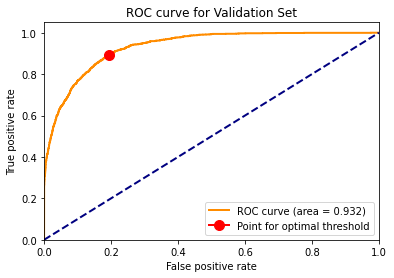

In [17]:
plot_roc_curve_with_treshold(X_train.iloc[n_first:], y_train.iloc[n_first:], model, fpr_optimum, tpr_optimum,"Validation")

**Model Metrics and Plots for the Test Set**

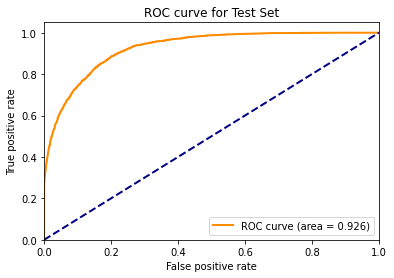

In [18]:
y_pred_test, fpr_test, tpr_test, threshold_test = plot_roc_curve(X_test, y_test, model,"Test")

In [19]:
#Converting probabilities into 1 or 0  for test set
for i in range(0,(y_pred_test.shape[0])):
    if y_pred_test[i]>=0.21393804:
        y_pred_test[i]=1
    else: 
        y_pred_test[i]=0 

              precision    recall  f1-score   support

           0       0.95      0.81      0.87     12312
           1       0.59      0.88      0.71      3964

    accuracy                           0.82     16276
   macro avg       0.77      0.84      0.79     16276
weighted avg       0.86      0.82      0.83     16276

Normalized confusion matrix
[[0.81 0.19]
 [0.12 0.88]]

Accuracy of the model : 0.8226837060702875


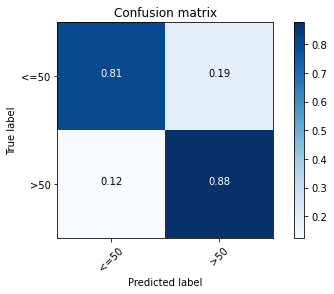

In [20]:
# Compute confusion matrix
cmf_pred= confusion_matrix(y_test, y_pred_test)
np.set_printoptions(precision=2)

print (classification_report(y_test, y_pred_test.reshape(-1)))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cmf_pred, classes=['<=50','>50'],normalize= True,  title='Confusion matrix')

#calculating accuracy of our model 
from sklearn.metrics import accuracy_score 
accuracy_xgb = accuracy_score(y_test, y_pred_test) 
print('''''')
print('Accuracy of the model :', accuracy_xgb)